<a href="https://colab.research.google.com/github/MeghaPujamath/Reinforcement-Learning---DQN-for-cartpole-environment-/blob/main/DeepQNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [191]:
import torch
from torch import nn
import random
import gym
import itertools
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import deque

import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image

In [192]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [193]:
torch.set_grad_enabled(True)

HyperParameters

In [194]:
batch_size = 32 #No of transitions that we sample from replay buffer while calculating gradients
n_episodes = 1001
discountFactor = 0.99
epsilon = 1.0
epsilonFactor = 10000
minEpsilon = 0.02
learning_rate = 0.001
buffer_size = 50000 #Max No of trqnsitions that we store before clearing out
min_replay_size = 1000 #No of transitions stored in replay buffer before we start computing gradients and training
target_update_fre = 1000 #no of steps that we update target paramters equal to online parameters
episode_length = 100
episode_durations = []

Initializing Env

In [195]:
env = gym.make('CartPole-v0')
# memory = deque(maxlen=buffer_size)
reward_buffer = deque([0.0], maxlen=100)

state_size = env.observation_space.shape
action_size = env.action_space.n

/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:594: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  f"The environment {id} is out of date. You should consider "
/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in futu

Model

In [196]:
class ModelNetwork(nn.Module):
  def __init__(self, env):
    super().__init__()
    input_features = int(np.prod(state_size))
    self.net = nn.Sequential(
        nn.Linear(input_features, 64), 
        nn.Tanh(),
        nn.Linear(64, action_size))

  def forward(self, x):
    return self.net(x)


Initialize online and target Network

In [197]:
main_net = ModelNetwork(env) #Main network is actually trained
target_net = ModelNetwork(env) #target network is used to generate target values or ground truth

target_net.load_state_dict(main_net.state_dict())
optimizer = torch.optim.Adam(main_net.parameters(), learning_rate)

In [198]:
class DQNAgent():
  def __init__(self):
    self.loss_fn = torch.nn.MSELoss()

  def act(self, state):
    # with torch.no_grad():
    state_t = torch.as_tensor(state, dtype=torch.float32) #converting state to torch tensor
    q_values = main_net(state_t.unsqueeze(0)) #Creating fake batch dimensions of 1

    max_q_index = torch.argmax(q_values, dim=1)[0]
    action = max_q_index.detach().item() # converting torch tensor to integer
    return action
  
  def trainNetwork(self, batch_size, minibatch):
    states = np.asarray([m[0] for m in minibatch])
    actions = np.asarray([m[1] for m in minibatch])
    rewards = np.asarray([m[2] for m in minibatch])
    next_states = np.asarray([m[3] for m in minibatch])
    dones = np.asarray([m[4] for m in minibatch])

    states_t = torch.as_tensor(states, dtype=torch.float32)
    actions_t = torch.as_tensor(actions, dtype=torch.int64).unsqueeze(-1)
    rewards_t = torch.as_tensor(rewards, dtype=torch.float32).unsqueeze(-1)
    done_t = torch.as_tensor(dones, dtype=torch.float32).unsqueeze(-1)
    next_states_t = torch.as_tensor(next_states, dtype=torch.float32)

    #Actual q values or ground truth from target network using next state
    target_q_values = target_net(next_states_t) 
    max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
    targets = rewards_t + discountFactor*(1-done_t)*max_target_q_values
    # test = torch.tensor(targets, requires_grad=True)

    #Predicted q values from main network using current state
    q_values = main_net(states_t)
    # action_q_values, _ = torch.max(q_values, axis=1)
    action_q_values = torch.gather(input=q_values, dim=1, index=actions_t)
    # test2 = torch.tensor(action_q_values, requires_grad=True)

    #Compute Losses
    # loss = nn.functional.smooth_l1_loss(action_q_values, targets)
    loss = self.loss_fn(action_q_values, targets)

    #Gradient Descent Step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

Initialize Replay buffer

In [199]:
class ReplayBuffer:
  def __init__(self, buffer_size=buffer_size):
    self.buffer_size = buffer_size
    self.buffer = deque(maxlen=self.buffer_size)
  
  def insert_replayBuffer(self, state, action, reward, next_state, done):
    self.buffer.append((state, action, reward, next_state, done))
  
  def sample_replayBuffer(self, batch_size):
    return random.sample(self.buffer, batch_size)
  
  def buffer_initialization(self, env, min_replay_size):
    state = env.reset()
    for _ in range(min_replay_size):
      action = env.action_space.sample()
      next_state, reward, done, _ = env.step(action)
      self.insert_replayBuffer(state, action, reward, next_state, done)

      state = next_state
      if done:
        state = env.reset()


Main loop


In [200]:
agent = DQNAgent()
rb = ReplayBuffer()
rb.buffer_initialization(env, min_replay_size)
loss_test, losses_list, reward_list, episode_len_list, epsilon_list, mean_reward_list  = [], [], [], [], [], []
episode_len, losses, episode_reward, steps = 0, 0, 0, 0
state = env.reset()
for i in range(1000):
for i in itertools.count():
  #Choose action based on epsilon value, either exploring or exploiting
  action = env.action_space.sample()
  if torch.rand(1,).item() > epsilon:
    action = agent.act(state)
    
  next_state, reward, done, _ = env.step(action)
  rb.insert_replayBuffer(state, action, reward, next_state, done)

  state = next_state
  episode_reward += reward
  steps += 1
  if done:
    env.reset()
    reward_buffer.append(episode_reward)
    reward_list.append(episode_reward)
    episode_len +=1

  miniBatch = rb.sample_replayBuffer(batch_size)
  loss = agent.trainNetwork(batch_size, miniBatch)
  losses += loss

  if i % target_update_fre== 0:
    target_net.load_state_dict(main_net.state_dict())

  if done:
    episode_durations.append(steps)
    losses_list.append(losses/episode_len)
    loss_test.append(losses)
    
    mean_reward_list.append(np.mean(reward_list))
    episode_len_list.append(episode_len)
    epsilon_list.append(epsilon)
    print("{4} Episode {0} finished after {1} steps with reward {2} and avg reward {3}"
                .format(episode_len, steps, episode_reward ,np.mean(reward_list), '\033[92m' if steps >= 195 else '\033[99m'))
    if epsilon > 0.05 :
      epsilon -= (1 / 5000)
    episode_reward = 0.0
    if(episode_len > 1500):
      break

 Episode 1 finished after 55 steps with reward 55.0 and avg reward 55.0
 Episode 2 finished after 65 steps with reward 10.0 and avg reward 32.5
 Episode 3 finished after 82 steps with reward 17.0 and avg reward 27.333333333333332
 Episode 4 finished after 94 steps with reward 12.0 and avg reward 23.5
 Episode 5 finished after 133 steps with reward 39.0 and avg reward 26.6
 Episode 6 finished after 166 steps with reward 33.0 and avg reward 27.666666666666668
 Episode 7 finished after 192 steps with reward 26.0 and avg reward 27.428571428571427
 Episode 8 finished after 205 steps with reward 13.0 and avg reward 25.625
 Episode 9 finished after 249 steps with reward 44.0 and avg reward 27.666666666666668
 Episode 10 finished after 263 steps with reward 14.0 and avg reward 26.3
 Episode 11 finished after 284 steps with reward 21.0 and avg reward 25.818181818181817
 Episode 12 finished after 296 steps with reward 12.0 and avg reward 24.666666666666668
 Episode 13 finished after 323 steps wi

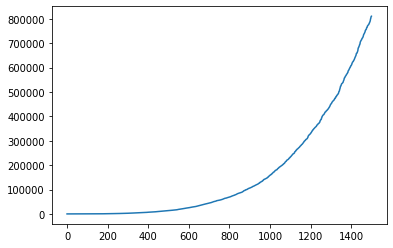

In [204]:
plt.plot(epsilon_list)

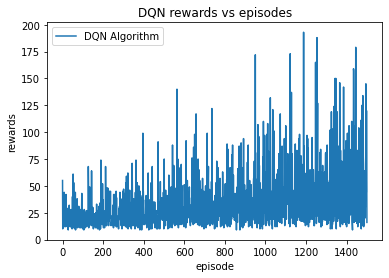

In [202]:
x = [i+1 for i in range(len(reward_list))]
fig, ax = plt.subplots()
plt.title('DQN rewards vs episodes')
plt.plot(reward_list, label='DQN Algorithm')
#plt.plot(x, running_avg2, label='PPO Algorithm')
plt.xlabel("episode")
plt.ylabel("rewards")
plt.legend()
plt.show()